# shower-event.py
https://github.com/grand-mother/grand/blob/master/examples/simulation/shower-event.py

In this example we compute the voltage at antenna output for a given simulated shower. This consist basically in a scalar product between the Efield vector and the antenna effective length, the complex vectorial information encoding the antenna response:
$$ V = \vec{E} \cdot \vec{l_{eff}}$$

More details on the effective length & voltage computation can be found in particular here: https://github.com/grand-mother/hands_on/blob/master/GRANDscripts/GRANDscripts.pdf





First we import relevant packages.




In [1]:
#! /usr/bin/env python
import numpy as np
from matplotlib import pyplot as plt
from astropy.coordinates import BaseRepresentation, CartesianRepresentation
import astropy.units as u

From GRAND, most important modules are Antenna (https://github.com/grand-mother/grand/blob/master/grand/simulation/antenna/generic.py) and ShowerEvent (https://github.com/grand-mother/grand/blob/master/examples/simulation/shower-event.py). 

Two important remarks:
- For the purpose of illustration in this example, jupyter notebooks defining these classes are used here for these classes rather than their (standard) python implementation. THis allows additionnal printing & plotting.
- "Kernel restart" is necessary if you want any modification that you may apply for test purposes to these notebooks to be taken into account. 

In [2]:
#from grand.simulation import Antenna, ShowerEvent, TabulatedAntennaModel
from grand import ECEF, LTP
from grand.simulation import ShowerEvent

## Import notebooks derived from the standard scripts
from ipynb.fs.full.antenna import *
from ipynb.fs.full.tabulated import *
from ipynb.fs.full.shower_generic import *

#from ipynb.fs.full.zhaires import *
#%matplotlib notebook

Now we load the Shower object from the (Zhaires) example file, available through this command: 

> wget https://github.com/grand-mother/store/releases/download/101/zhaires-test.tar.gz

Note: the method to load the object directly from sim output is only temporary. Soon enough this will be replaced through readuing from a (standardized) simulation file (HDF5 or ROOT).

In [3]:
# Load the radio shower simulation data
shower = ShowerEvent.load('../../tests/simulation/data/zhaires')

print("Shower framinp['core']e=",shower.frame)
print("Zenith (Zhaires conv) =",shower.zenith)
print("Azimuth (Zhaires conv) =",shower.azimuth)
print("Xmax=",shower.maximum)
#shower.core=CartesianRepresentation(0, 0, 2900, unit='m')
print("Core=",shower.core)

### zhaires.py: reading groundaltitude from. inp file.
Shower framinp['core']e= <LTP Frame (location=(-202152.61540589, 4968285.91242108, 3981091.07392567) m, orientation=NWU, magnetic=True, declination=0.72 deg, rotation=None, obstime=2019-10-31 00:00:00)>
Zenith (Zhaires conv) = 85.2 deg
Azimuth (Zhaires conv) = 0.0 deg
Xmax= (150.75, 0., 12.66) km
Core= (0., 0., 0.) m


The shower is associated with a Local Tangeant Plane frame centered on the shower core. Hence the Xmax altitude given here is the height above ground, and not above sea level.

Note: using ground altitude at the reference might not be the most natural choice. Sea level is probably more convenient (and less error-prone!)

Now we load the Antenna model, which contains the effective length information, under the form of 4 matrixes (modulus and phase for the 2 componants $l_{eff}^{\theta}$ and $l_{eff}^{\phi}$) with 3 dimensions (frequency, zenith, angle). 

This is done here: https://github.com/grand-mother/grand/blob/be5333a4abfd0f0c0b30835e65c689bfcc798f04/grand/simulation/antenna/tabulated.py#L47


In [4]:
# Define an antenna model
#
# A tabulated model of the Butterfly antenna is used. Note that a single EW
# arm is assumed here for the sake of simplicity

antenna_model = TabulatedAntennaModel.load('./HorizonAntenna_EWarm_leff_loaded.npy')

Loading tabulated antenna model from ./HorizonAntenna_EWarm_leff_loaded.npy:/
Loaded 1841112 entries from ./HorizonAntenna_EWarm_leff_loaded.npy:/


We then loop on all antennas.

antenna.computevoltage is called with parameters:
- direction = vector $\vec{X_{max}X_{ant}}$
- Electric field info at this antenna
- antenna frame (LTP centered at antenna)

In compute voltage, we do the following: 
- Convert the Efield timetraces ($E_x(t),E_y(t),E_z(t)$) expressed in the Efield frame, an LTP centered @ core) in the frequency domain through FFT
- Compute the Leff values for the direction "direction" where the radiation comes from. These are interpolatted from tabulated values in https://github.com/grand-mother/grand/blob/be5333a4abfd0f0c0b30835e65c689bfcc798f04/grand/simulation/antenna/tabulated.py#L123.
- Write the Leff vector in the E_field frame.
- Perform the scalar product $\vec{E} \cdot \vec{L_{eff}}$ in the frequency domain and come back to the time domain through inverse Fourier transform.

Result is $V(t)$ for this (EW) antenna arm.


#### 0 Antenna pos= (0., 270.45, 0.) m
Direction to Xmax =  (150.75, -0.27045, 12.66) km
### Now in Antenna:ComputeVoltage
We have an antenna frame: <LTP Frame (location=(-201882.32363128, 4968294.775713, 3981093.71989078) m, orientation=NWU, magnetic=True, declination=None, rotation=None, obstime=2019-10-31 00:00:00)>
We have a shower frame: <LTP Frame (location=(-202152.61540589, 4968285.91242108, 3981091.07392567) m, orientation=NWU, magnetic=True, declination=0.72 deg, rotation=None, obstime=2019-10-31 00:00:00)>
dir_frame =  <LTP Frame (location=(-202152.61540589, 4968285.91242108, 3981091.07392567) m, orientation=NWU, magnetic=True, declination=0.72 deg, rotation=None, obstime=2019-10-31 00:00:00)>
Direction to Xmax in antenna frame: 85.19956656663308 359.89720977150995
Compute Leff for (antenna framework) direction ( 85.19956656663308 , 359.89720977150995 )


Vpp= 43.38335549763258 uV


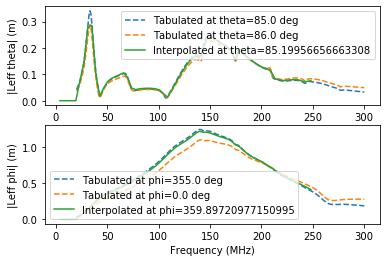

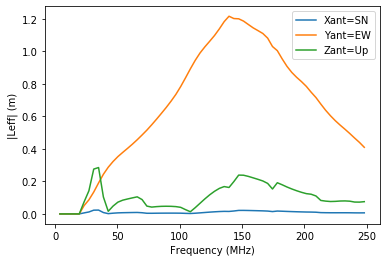

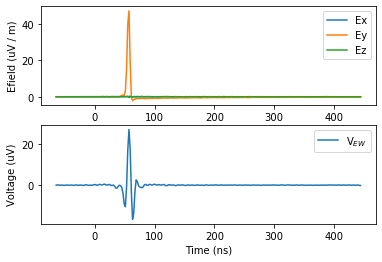

In [ ]:
# Loop over electric fields and compute the corresponding voltages
for antenna_index, field in shower.fields.items():
    # Compute the antenna local frame
    #
    # The antenna is placed within frequencythe shower frame. It is oriented along the
    # local magnetic North by using an ENU/LTP frame (x: East, y: North, z: Upward)
    antenna_location = shower.frame.realize_frame(field.electric.r)
    print("####",antenna_index,"Antenna pos=",field.electric.r)

    antenna_frame = LTP(location=antenna_location, orientation='NWU',magnetic=True, obstime=shower.frame.obstime)
    antenna = Antenna(model=antenna_model, frame=antenna_frame)


    # Compute the voltage on the antenna
    #
    # The electric field is assumed to be a plane-wave originating from the
    # shower axis at the depth of maximum development. Note that the direction
    # of observation and the electric field components are provided in the
    # shower frame. This is indicated by the `frame` named argument.
    direction = shower.maximum - field.electric.r
    print("Direction to Xmax = ",direction)
    
    
    Exyz = field.electric.E.represent_as(CartesianRepresentation)

    field.voltage = antenna.compute_voltage(direction, field.electric,frame=shower.frame)

    
    plt.figure()
    plt.subplot(211)
    plt.plot(field.electric.t,Exyz.x,label='Ex')
    plt.plot(field.electric.t,Exyz.y,label='Ey')
    plt.plot(field.electric.t,Exyz.z,label='Ez')
    plt.xlabel('Time ('+str(field.electric.t.unit)+')')
    plt.ylabel('Efield ('+str(Exyz.x.unit)+')')
    plt.legend(loc='best')
    plt.subplot(212)
    plt.plot(field.voltage.t,field.voltage.V,label='V$_{EW}$')
    plt.xlabel('Time ('+str(field.voltage.t.unit)+')')
    plt.ylabel('Voltage ('+str(field.voltage.V.unit)+')')
    plt.legend(loc='best')
    print("Vpp=",max(field.voltage.V)-min(field.voltage.V))
    plt.show()
    input("Type return for next antenna")
    
